<a href="https://colab.research.google.com/github/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/main/Avance2_Equipo7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Integrador


## Tecnológico de Monterrey
### Maestría en Inteligencia Artificial Aplicada (MNA)
#### Avance 2
#### Equipo 7


* Jorge Arturo Federico Rivera – A01250724
* Marco Antonio Vázquez Morales – A01793704
* Alejandro Jesús Vázquez Navarro - A01793146

### Ingeniería de Características

Proyecto:

*Modelo clasificador de multimorbilidad maternal y predictor de desenlaces perinatales a partir de datos clínicos metabólicos, genéticos y nutricionales de mujeres mexicanas*

12 de mayo de 2024

# 1. Construcción

Tomaremos el dataframe `dfPreparado` que preparamos en la **Fase i**, ahora aplicaremos la construcción de la variable dependiente y la inclusión de nuevas características. Por ejemplo, la variable `prematurez` se basará en el número de semanas de la variable `sdg_parto`.

A continuación las reglas de creación de características:

- **Prematurez** [variable nueva] En función al valor de la variable `sdg_parto` se determinará si el valor es **1** o **0**. La regla es: Si el valor es menor a 36, entonces será prematuro (1), caso contrario el valor será no prematura (0).
- **EscalaRiesgo** [variable dependiente] Clasificación que tomará como base la suma de '1' en las 8 características indicadas por el cuerpo médico + nueva característica: `prematurez`. Con base en este valor, obtendremos los siguientes valores:
  - **A**: Alto riesgo: Puntuación 3 y 4
  - **B**: Medio riesgo: Puntuación entre 1 y 2
  - **C**: Riesgo bajo: Puntuación 0

- **Clúster asociado** Después de correr un algoritmo de clustering, agregaremos al dataframe _dfPreparado_ el número de clúster asociado.

Además, crearemos variables con one hot encoding para la variable `macrosomia_rn`. Dicha variable tiene un vector de valores que comprende ratios, por ejemplo: 1/0 y 0/0


### 1.1. Funciones ad hoc

In [45]:
def definePrematurez(sdg_parto):
  if sdg_parto > 36:
    return 0
  else:
    return 1

def defineClase(valor_IndexMorbilidad):
  if valor_IndexMorbilidad ==3 or valor_IndexMorbilidad==4:
    return "A"
  elif valor_IndexMorbilidad ==1 or valor_IndexMorbilidad==2:
    return "B"
  else:
    return "C"

def identify_binary(data):

  binary_cols = []
  for col in data.columns:
    unique_values = data[col].dropna().unique()
    #print(f'Col name {col} unique values {unique_values}')

    if len(unique_values) == 2 and (set(unique_values) == {0, 1}):

      binary_cols.append(col)
  return binary_cols

### 1.2 Librerías

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

### 1.3 Carga de datos

In [6]:
# Adquisisicón de datos

dfPreparado = pd.read_csv("data/dataset_proxima_fase.csv", encoding='utf8')
dfPreparado.head()

,id_gdg,origen_px,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,...,peso_3,sdg_dx,anticonceptivo,no_gestas,sdg_parto,peso_2,supl_1erTrim,ldl_dx,modo_parto,macrosomia_rn
0,DG37D44,DF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.554037,2.0,0.631653,3.0,37.452049,68.963291,0.843066,113.255088,0.0,1
1,DG28M97,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,1.0,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,0.0,1
2,DG73R77,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1
3,DG63E13,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1
4,DG61O38,Guerrero,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,72.554037,0.0,0.631653,4.0,37.452049,68.963291,0.843066,113.255088,1.0,1


### 1.4 Variable Prematurez

In [12]:
dfPreparado["prematurez"] = dfPreparado['sdg_parto'].apply(lambda x:definePrematurez(x))

,id_gdg,origen_px,biopsias,obs_h,ichos_pregesta,hta_pregesta,sop,hipotiroidismo,hipertiroidismo,consumo_alcohol,...,anticonceptivo,no_gestas,sdg_parto,peso_2,supl_1erTrim,ldl_dx,modo_parto,macrosomia_rn,dfFinal,prematurez
0,DG37D44,DF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.631653,3.0,37.452049,68.963291,0.843066,113.255088,0.0,1,0.0,0
1,DG28M97,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,0.0,1,0.0,0
2,DG73R77,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1,0.0,0
3,DG63E13,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.631653,2.0,37.452049,68.963291,0.843066,113.255088,1.0,1,2.0,0
4,DG61O38,Guerrero,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.631653,4.0,37.452049,68.963291,0.843066,113.255088,1.0,1,0.0,0


#### 1.4.1 Revisar distribución de la nueva variable.


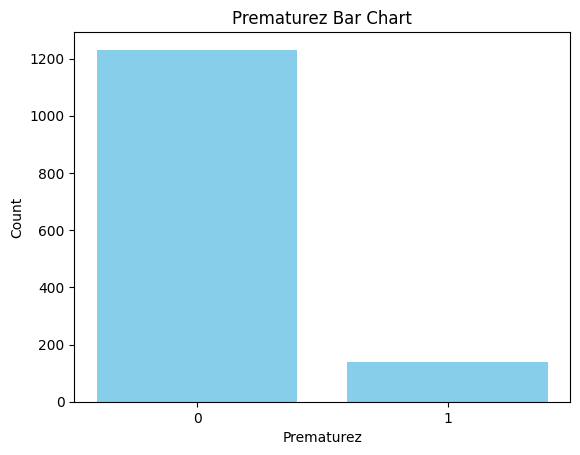

In [20]:
prematurez_counts = dfPreparado['prematurez'].value_counts()
prematurez_counts = prematurez_counts.sort_index()
plt.bar(prematurez_counts.index, prematurez_counts.values, color='skyblue')
plt.xticks(list(map(int, prematurez_counts.index)))

plt.title('Prematurez Bar Chart')
plt.xlabel('Prematurez')
plt.ylabel('Count')
plt.show()

### 1.5 Variable dependiente

In [32]:
lst_IndexMorbilidad = ['malformaciones_rn', 'aborto_rn','obito_rn','mnt_rn','preeclampsia', 'polihidramnios', 'hidramnios', 'infeccion_gesta', 'prematurez']
dfPreparado["IndexMorbilidad"] = dfPreparado[lst_IndexMorbilidad].sum(axis=1)
dfPreparado["EscalaRiesgo"] =  dfPreparado['IndexMorbilidad'].apply(lambda x:defineClase(x))


#### 1.6 Revisar la distribución de la variable dependiente **EscalaRiesgo**

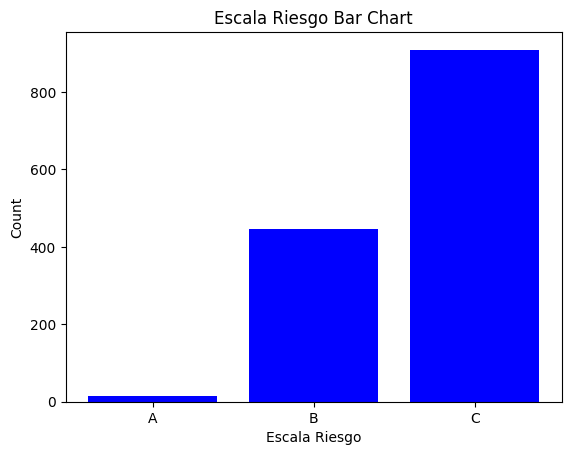

In [39]:
escala_riesgo = dfPreparado['EscalaRiesgo'].value_counts()
escala_riesgo = escala_riesgo.sort_index()
plt.bar(escala_riesgo.index, escala_riesgo.values, color='blue')
plt.title('Escala Riesgo Bar Chart')
plt.xlabel('Escala Riesgo')
plt.ylabel('Count')
plt.show()

# 2. Normalización

En esta fase, realizaremos escalamiento de las variables numéricas pues, derivado del análisis de la **Fase 1** encontramos diferentes outliers que pueden desestabilizar el modelo base y subsecuentes.

Utilizaremos un Pipeline para crear la canalización para aplicar las transformaciones.




In [52]:
binary_features = identify_binary(dfPreparado)

all_cols = set(dfPreparado.columns)
cols_to_remove_from_numeric =["macrosomia_rn", "id_gdg", "origen_px"]

numeric_features = [x for x in all_cols if x not in binary_features]
numeric_features = [x for x in numeric_features if x not in cols_to_remove_from_numeric]
numeric_features.remove("IndexMorbilidad")
numeric_features.remove("EscalaRiesgo")

categorical_features  =["macrosomia_rn"]

print(numeric_features)

['estado', 'supl_1erTrim', 'dx_inicio', 'edad_dx', 'gluc_dx_60', 'peso_2', 'modo_parto', 'imc_h', 'sdg_dx', 'nivel_ses', 'puntos_ses', 'gluc_dx_120', 'gluc_dx_0', 'dfFinal', 'ac_fol_gesta', 'ldl_dx', 'tg_dx', 'peso_3', 'auc', 'escolaridad', 'sdg_fol', 'trim_fol', 'ac_fol_dosis_mg', 'ins_dx', 'ant_aborto', 'termino_rn', 'alta_paridad', 'sdg_parto', 'ct_dx', 'no_gestas', 'peso_1', 'iniciosupl_sdg', 'hdl_dx', 'anticonceptivo', 'gluc_dx_180', 'gluc_dx']


In [54]:


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale numerical features
])

# Create pipeline for preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(dfPreparado)

# Fit and transform the data
transformed_data = pipeline.transform(dfPreparado)


# Get feature names for numeric and one-hot encoded categorical variables
numeric_feature_names = numeric_features
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_feature_names + list(categorical_feature_names)

transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
print(transformed_df)

transformed_df.to_csv("transformed_df.csv")

        estado  supl_1erTrim     dx_inicio   edad_dx  gluc_dx_60  \
0     0.681514      0.000000  1.598529e-01  0.163045    0.879560   
1     0.681514      0.000000  1.598529e-01  1.209585    1.164556   
2     0.681514      0.000000  1.058485e+00  0.910574    1.212055   
3     0.681514      0.000000  1.058485e+00 -0.434977    1.022058   
4     0.681514      0.000000  1.598529e-01  1.359091    1.259555   
...        ...           ...           ...       ...         ...   
1365  0.000000      0.939187 -1.995365e-16 -0.883494    0.000000   
1366  0.000000      0.939187 -1.995365e-16  0.312551    0.000000   
1367 -0.944234      0.939187 -7.387796e-01 -0.733989   -1.899148   
1368 -0.944234      0.000000 -1.995365e-16 -2.378551    0.000000   
1369  0.000000      0.939187 -1.995365e-16 -1.481517    0.000000   

            peso_2  modo_parto     imc_h    sdg_dx     nivel_ses  ...  \
0     1.509837e-15   -2.327581 -0.940504  1.201108 -1.139511e-15  ...   
1     1.509837e-15   -2.327581  0.070

# Selección / Extracción

# Conclusiones